# pu_pmsm

> per unit equations of pmsm and their corresponding torque-speed profiles

In [ ]:
#| default_exp pu_pmsm

In [ ]:
#| hide
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt

### pmsms per unit analysis

Ideal PMSM model in p.u ignoring resistance

$V = \omega \sqrt{ (\lambda_m - L_d i_d )^2 + (L_q i_q )^2 }$  
$T = \dfrac{3 p}{2} [\lambda_m i_q + (L_q - L_d)i_q i_d]$  
$i_d = I \sin(\gamma)$  
$i_q = I \cos(\gamma)$

### Theory: spm pu analysis implementation
spm class provides the ideal per unit capability of the machine defined by two parameters   
1. flux linkage ($\lambda_m$) = phi_m  
2. inductance ($L_d = L_q = L$) = lpu    

SPM achieves maximum torque per ampere with $\gamma = 0$.   
At base speed, $V$, $\omega$ have 1 p.u value.    
Considering these SPM specific constraints at base speed, $\lambda_m$ and $L$ are bound by    
$1 = \sqrt{\lambda_m^2 + L^2 }$     

In this implementation, SPM machine is characterized by just $L$ i.e $lpu$ as input. $\lambda_m$ is calculated using the above constraint.   

In [ ]:
#| export
class spm():
    def __init__(self, phi_m):
        self.lpu = np.sqrt(1-phi_m**2)
        self.phi_m = phi_m
        self.Vb = 0
        self.Pb = 0
        self.wb = 0
        self.speed = []
        self.torque = []
        self.voltage = []
        self.current = []
        self.gamma = []
        self.power = []
        self.values = dict.fromkeys(['speed', 'torque', 'power'])
            
    def motor_puprofile(self, gamma_limit = 85):
        """ this method calculates the per unit profile of the machine with current angle limit of 85 degrees
        """
        gamma_deg = 0
        gamma = gamma_deg*np.pi/180
        # constant torque region
        for o in np.arange(0,1.1,0.1):
            v = o * np.sqrt( (self.phi_m - np.sin(gamma)*self.lpu)**2 + (self.lpu * np.cos(gamma))**2 )
            t = self.phi_m * np.cos(gamma)
            p = t*o
            self.speed.append(o)
            self.voltage.append(v)
            self.gamma.append(gamma)
            self.torque.append(t)
            self.power.append(p)
        # constant voltage region
        for gamma_deg in range(1,85):
            gamma = gamma_deg*np.pi/180
            o = 1/np.sqrt( (self.phi_m - np.sin(gamma)*self.lpu)**2 + (self.lpu * np.cos(gamma))**2 )
            t = self.phi_m * np.cos(gamma)
            p = t*o
            self.speed.append(o)
            self.voltage.append(v)
            self.gamma.append(gamma_deg)
            self.torque.append(t)
            self.power.append(p)
    
    def motor_profile(self, Vb, Pb, wb):
        """This method takes Vb, Pb, wb as the base values for line voltage, KVA rating of the machine, base speed respectively
        """
        self.Vb = Vb
        self.Pb = Pb
        self.wb = wb
        Tb = Pb/(2*np.pi*wb/60)
        self.values['speed'] = np.array(self.speed)*wb
        self.values['torque'] = np.array(self.torque)*Tb
        self.values['power'] = np.array(self.power)*Pb
        
    
    def plot_puprofile(self):
        """ plots the motor performance profile in p.u
        """
        fig, axs = plt.subplots(3)
        fig.set_figheight(8)
        axs[0].plot(self.speed, self.torque)
        axs[0].set_title('torque vs speed')
        axs[1].plot(self.speed, self.power)
        axs[1].set_title('power vs speed')
        axs[2].plot(self.speed, self.gamma)
        axs[2].set_title('gamma vs speed')
        
        # Hide x labels and tick labels for top plots and y ticks for right plots.
        for ax in axs.flat:
            ax.label_outer()
        
        plt.tight_layout()
        plt.show()
    
    def plot_profile(self):
        """ plots the motor performance profile in actual values
        """       
        fig, axs = plt.subplots(3)
        fig.set_figheight(8)
        axs[0].plot(self.values['speed'], self.values['torque'])
        axs[0].set_title('torque vs speed')
        axs[1].plot(self.values['speed'], self.values['power'])
        axs[1].set_title('power vs speed')
        axs[2].plot(self.values['speed'], self.gamma)
        axs[2].set_title('gamma vs speed')
        
        # Hide x labels and tick labels for top plots and y ticks for right plots.
        for ax in axs.flat:
            ax.label_outer()
        
        plt.tight_layout()
        plt.show()

In [ ]:
show_doc(spm.motor_puprofile)

---

### spm.motor_puprofile

>      spm.motor_puprofile (gamma_limit=85)

this method calculates the per unit profile of the machine with current angle limit of 85 degrees

In [ ]:
show_doc(spm.motor_profile)

---

### spm.motor_profile

>      spm.motor_profile (Vb, Pb, wb)

This method takes Vb, Pb, wb as the base values for line voltage, KVA rating of the machine, base speed respectively

In [ ]:
show_doc(spm.plot_puprofile)

---

### spm.plot_puprofile

>      spm.plot_puprofile ()

plots the motor performance profile in p.u

In [ ]:
show_doc(spm.plot_profile)

---

### spm.plot_profile

>      spm.plot_profile ()

plots the motor performance profile in actual values

### spm class use: example

Machine profile with:       
magnet flux linkage = 0.8 p.u       
line-line base voltage = 42 V       
base power value (available KVA) = 7000 W   
base speed = 2500 rpm

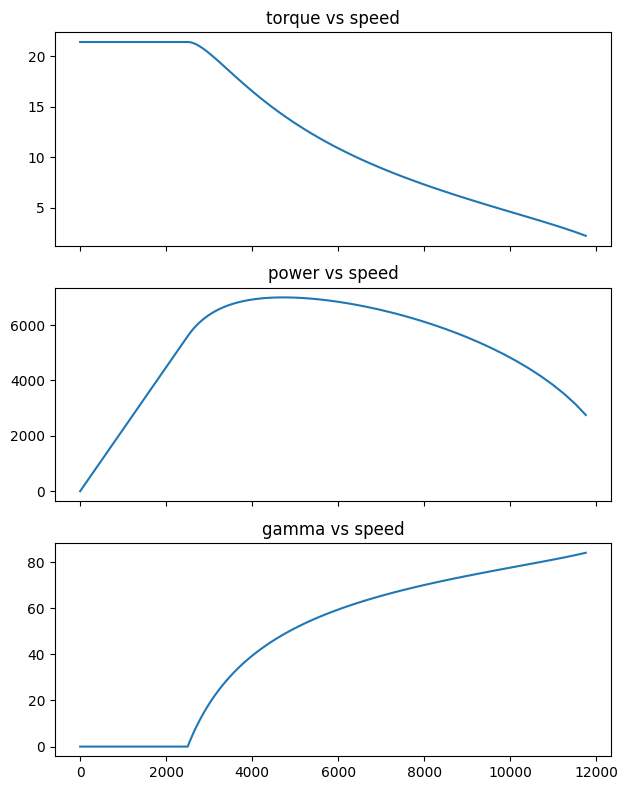

In [ ]:
#| hide_output
M1 = spm(0.8)
M1.motor_puprofile()
M1.motor_profile(42, 7000, 2500)
M1.plot_profile()

## Theory: IPM pu analysis and impelmentation

$\eta = \dfrac{L_q}{L_d}$    
$V = \omega \sqrt{ (\lambda_m - L_d \cos(\gamma) )^2 + (\eta L_d \sin(\gamma) )^2 }$  
$T = \dfrac{3 p}{2} [\lambda_m \cos(\gamma) + (\eta - 1) L_d  \dfrac{sin(2\gamma)}{2}]$ 

* The machine should operate with maximum torque per ampere decided by the current angle $\gamma$
* $\gamma$ is dependent on the values of $\lambda_m, L_d, \eta$
* The machine MTPA operation at base speed should achieve 1 p.u. voltage value

$\gamma_{MTPA} = \sin^{-1} \Big[ \dfrac{-\lambda_m + \sqrt{ \lambda_m^2 + 8xx^2} }{4xx} \Big] $     
where, $xx = L_d(\eta - 1)$. However the above expression is only valid if $\eta > 1$   

Several possible combinations of $\lambda_m, L_d, \eta$ can achieve given torque-speed characterisitic. To achieve ideal field weakening however, there exists a unique combination of $\lambda_m = L_d$ and $\eta$.

In [ ]:
#| export
#export
class ipm():
    def __init__(self, phi_m, ld):
        self.phi_m = phi_m
        self.sal = 0
        self.ld = ld
        self.Vb = 0
        self.Ib = 0
        self.Pb = 0
        self.wb = 0
        self.speed = []
        self.torque = []
        self.voltage = []
        self.current = []
        self.gamma = []
        self.power = []
        self.values = dict.fromkeys(['speed', 'torque', 'power'])
        self.valid = 0
    

    def calc_sal(self):
        """ calculate valid saliency ratio for given combination of magnet flux linkage and inductance
        """
        for eta in np.arange(1.1, 20, 0.1):
            gamma = np.arcsin((-self.phi_m + np.sqrt( (self.phi_m**2 + 8*(self.ld*(self.sal-1))**2 )))/(4*self.ld*(self.sal-1)))
            volt = np.sqrt( (self.phi_m - self.ld*np.sin(gamma))**2 + (eta*self.ld * np.cos(gamma))**2 )
            if eta == 1.1 and volt > 1.05:
                self.valid = 0
                return
            if abs(volt-1) <= 0.05:
                self.sal = round(eta,1)
                break
            self.sal = round(eta,1)
    
    def validate(self,):
        """ validate the input machine parameter combinations
        """
        sin_gamma = (-self.phi_m + np.sqrt( (self.phi_m**2 + 8*(self.ld*(self.sal-1))**2 )))/(4*self.ld*(self.sal-1))
        if sin_gamma <= 1:
            self.valid = 1

    def motor_puprofile(self, gamma_limit = 85):
        """ this method calculates the per unit profile of the machine with current angle limit of 85 degrees
        """
        gamma = np.arcsin((-self.phi_m + np.sqrt( (self.phi_m**2 + 8*(self.ld*(self.sal-1))**2 )))/(4*self.ld*(self.sal-1)))
        gamma_deg = gamma*180/np.pi
        speed_temp = []
        voltage_temp = []
        gamma_temp = []
        torque_temp = []
        power_temp = []
        # constant torque region
        for o in np.arange(0,1.1,0.1):
            v = o * np.sqrt( (self.phi_m - self.ld*np.sin(gamma))**2 + (self.sal*self.ld * np.cos(gamma))**2 )
            t = self.phi_m * np.cos(gamma) + (self.sal-1)*self.ld*np.sin(2*gamma)/2
            p = t*o
            speed_temp.append(o)
            voltage_temp.append(v)
            gamma_temp.append(gamma_deg)
            torque_temp.append(t)
            power_temp.append(p)
            #self.speed.append(o)
            #self.voltage.append(v)
            #self.gamma.append(gamma_deg)
            #self.torque.append(t)
            #self.power.append(p)
        
        # constant voltage region
        while (gamma_deg < gamma_limit):
            gamma_deg += 1
            gamma = gamma_deg*np.pi/180
            o = 1/np.sqrt( (self.phi_m - np.sin(gamma)*self.ld)**2 + (self.sal* self.ld * np.cos(gamma))**2 )
            t = self.phi_m * np.cos(gamma) + (self.sal-1)*self.ld*np.sin(2*gamma)/2
            p = t*o
            speed_temp.append(o)
            voltage_temp.append(v)
            gamma_temp.append(gamma_deg)
            torque_temp.append(t)
            power_temp.append(p)

        self.speed = speed_temp
        self.voltage = voltage_temp
        self.gamma = gamma_temp
        self.torque = torque_temp
        self.power = power_temp
    
    def motor_profile(self, Vb, Pb, wb):
        """This method takes Vb, Pb, wb as the base values for line voltage, KVA rating of the machine, base speed respectively
        """
        self.Vb = Vb
        self.Pb = Pb
        self.wb = wb
        self.Ib = round((Pb*2/(3*Vb))*np.sqrt(3/2),2)
        Tb = Pb/(2*np.pi*wb/60)
        self.values['speed'] = np.array(self.speed)*wb
        self.values['torque'] = np.array(self.torque)*Tb
        self.values['power'] = np.array(self.power)*Pb

    
    def plot_puprofile(self):
        """ plots the motor performance profile in p.u
        """
        fig, axs = plt.subplots(3)
        fig.set_figheight(8)
        axs[0].plot(self.speed, self.torque)
        axs[0].set_title('torque vs speed')
        axs[1].plot(self.speed, self.power)
        axs[1].set_title('power vs speed')
        axs[2].plot(self.speed, self.gamma)
        axs[2].set_title('gamma vs speed')
        
        # Hide x labels and tick labels for top plots and y ticks for right plots.
        for ax in axs.flat:
            ax.label_outer()
        
        plt.tight_layout()
        plt.show()
    
    def plot_profile(self):
        """ plots the motor performance profile in actual values
        """       
        fig, axs = plt.subplots(3)
        fig.set_figheight(8)
        axs[0].plot(self.values['speed'], self.values['torque'])
        axs[0].set_title('torque vs speed')
        axs[0].set_xlim([0, 10000])
        axs[1].plot(self.values['speed'], self.values['power'])
        axs[1].set_title('power vs speed')
        axs[1].set_xlim([0, 10000])
        axs[2].plot(self.values['speed'], self.gamma)
        axs[2].set_title('gamma vs speed')
        axs[2].set_xlim([0, 10000])
        
        # Hide x labels and tick labels for top plots and y ticks for right plots.
        #for ax in axs.flat:
        #    ax.label_outer()
        
        plt.tight_layout()
        plt.show()

In [ ]:
show_doc(spm.motor_puprofile)

---

### spm.motor_puprofile

>      spm.motor_puprofile (gamma_limit=85)

this method calculates the per unit profile of the machine with current angle limit of 85 degrees

In [ ]:
show_doc(spm.motor_profile)

---

### spm.motor_profile

>      spm.motor_profile (Vb, Pb, wb)

This method takes Vb, Pb, wb as the base values for line voltage, KVA rating of the machine, base speed respectively

In [ ]:
show_doc(spm.plot_puprofile)

---

### spm.plot_puprofile

>      spm.plot_puprofile ()

plots the motor performance profile in p.u

In [ ]:
show_doc(spm.plot_profile)

---

### spm.plot_profile

>      spm.plot_profile ()

plots the motor performance profile in actual values

## ipm class use: example

Machine profile with:       
magnet flux linkage = 0.8 p.u       
saliency = 2        
Ld = 0.3 p.u              
line-line base voltage = 42 V       
base power value (available KVA) = 7000 W   
base speed = 2500 rpm

In [ ]:
#| hide_output
M2 = ipm(0.2, 0.35)
M2.calc_sal()
print("machine parameters validity: {}".format(M2.valid))
print("suggested machine saliency: {}".format(M2.sal))

machine parameters validity: 0
suggested machine saliency: 3.6


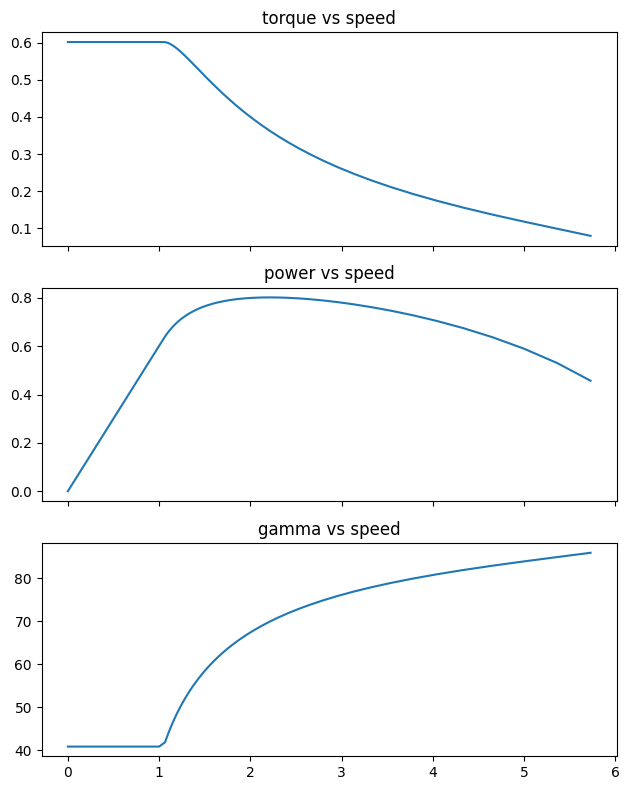

In [ ]:
#| hide_output
M2.motor_puprofile()
M2.plot_puprofile()

base current: 194.4 A rms
max torque: 22.98 N.m


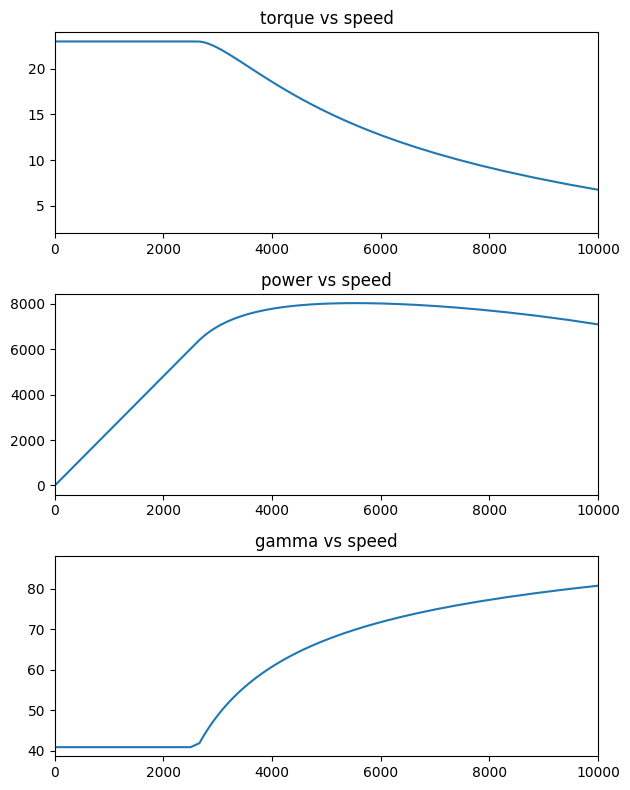

In [ ]:
#| hide_output
M2.motor_profile(42, 10000, 2500)
print('base current: {} A rms'.format(M2.Ib))
print('max torque: {} N.m'.format(round(max(M2.values['torque']),2)))
M2.plot_profile()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()